# VAE CelebA

This notebook is for implementing `Variational Auto-Encoder` with [Tensorflow](https://www.tensorflow.org). <br>
[CelebA dataset](https://www.kaggle.com/jessicali9530/celeba-dataset), which is 128x128 size, will be used. 

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import glob
import cv2 
import datetime
import os
from skimage.transform import resize

/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/frame

## Parameters


In [3]:
algorithm = 'VAE_CelebA'

img_size   = 128
img_resize_size = 64

batch_size = 128
num_epoch  = 10

n_latent = 128
z_dense_size = int(img_resize_size/16) * int(img_resize_size/16) * 256

learning_rate = 0.0002

show_result_step = 250

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190809-11-04-47_VAE_CelebA/model/model" 

## Import CelebA Dataset

Get names of the files in the celeba dataset folder.

In [4]:
celebA_list = glob.glob('./img_align_celeba/*.jpg')

print("CelebA dataset Length: {}".format(len(celebA_list)))

CelebA dataset Length: 202599


## Encoder

In [5]:
def Encoder(x, is_training):
    with tf.variable_scope('Encoder'):
        # First conv layer
        h1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='SAME')
        h1 = tf.nn.leaky_relu(h1)
        
        # Second conv layer
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=5, strides=2, padding='SAME')
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)
        
        # Trhid conv layer
        h3 = tf.layers.conv2d(h2, filters=256, kernel_size=5, strides=2, padding='SAME')
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        flatten = tf.reshape(h3, (-1, h3.get_shape()[1]*h3.get_shape()[2]*h3.get_shape()[3]))
        
        mean = tf.layers.dense(flatten, n_latent)
        std = tf.layers.dense(flatten, n_latent, activation=tf.nn.relu)
                
        return mean, std

## Decoder

In [6]:
def Decoder(z, is_training):
    with tf.variable_scope('Decoder'):
        
        z_dense = tf.layers.dense(z, z_dense_size)
        z_reshape = tf.reshape(z_dense, (-1, int(img_resize_size/16), int(img_resize_size/16), 256))
        
        # First deconv layer (output_shape =16x16)
        h1 = tf.layers.conv2d_transpose(z_reshape,filters=512, kernel_size=5, strides=2, padding='SAME')
        h1 = tf.nn.leaky_relu(h1)
        
        # Second deconv layer (output_shape = 32x32)
        h2 = tf.layers.conv2d_transpose(h1,filters=256, kernel_size=5, strides=2, padding='SAME')
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)  
        
        # Third deconv layer (output_shape = 64x64) 
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=2, padding='SAME')
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)

        # Output layer (output_shape = 128x128)
        logits = tf.layers.conv2d_transpose(h3, filters=3, kernel_size=5, strides=2, padding='SAME')     
        output = tf.sigmoid(logits)

        return logits, output

## VAE

In [7]:
def VAE(x, is_training):
    # Encoder
    mean, std = Encoder(x, is_training)
    
    # Sampling z
    z = mean + std * tf.random_normal(tf.shape(mean), 0, 1, dtype=tf.float32)
    
    # Decoder
    y_logit, y_output = Decoder(z, is_training)
    
    # loss
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=y_logit)
    KL_divergence = 0.5 * tf.reduce_mean(tf.square(mean) + tf.square(std) - tf.log(1e-8 + tf.square(std)) - 1, axis=1)

    loss = tf.reduce_mean(cross_entropy) + tf.reduce_mean(KL_divergence)
     
    return loss, tf.reduce_mean(cross_entropy), tf.reduce_mean(KL_divergence), mean, std, z, y_output    

## Build Graph

In [8]:
x = tf.placeholder(tf.float32, shape=[None, img_resize_size, img_resize_size, 3])
x_normalize = (tf.cast(x, tf.float32)/(255.0)) 

is_training = tf.placeholder(tf.bool)

loss, loss1, loss2, mean, std, z, y = VAE(x_normalize, is_training) 

# optimization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

## Initialization

In [9]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [10]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

## Train

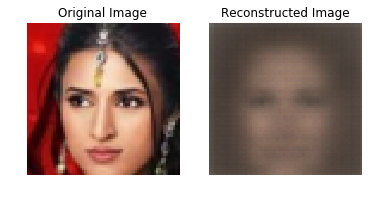

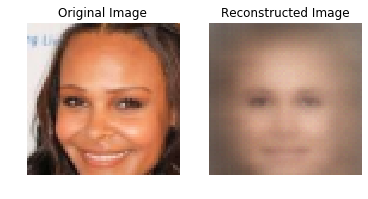

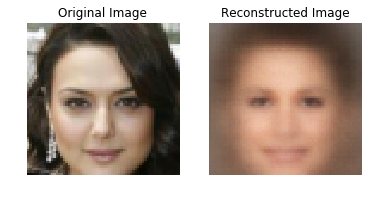

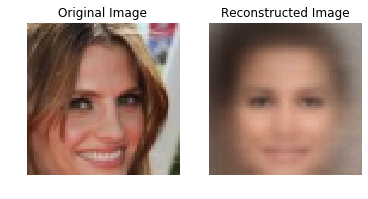

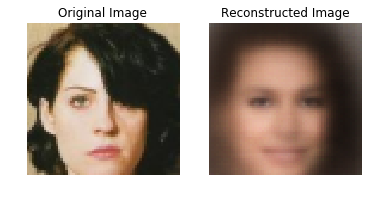

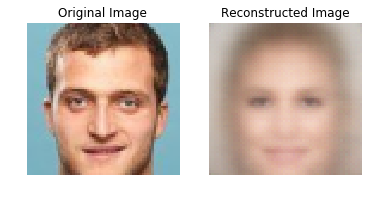

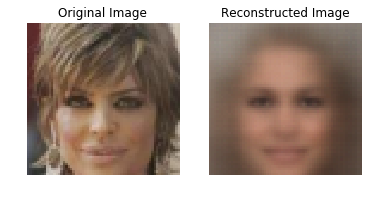

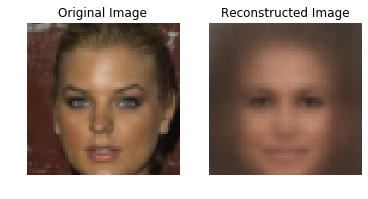

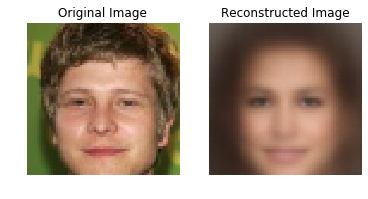

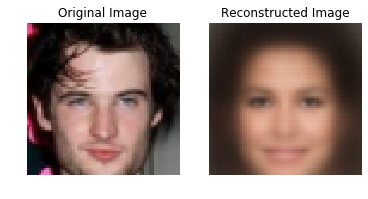

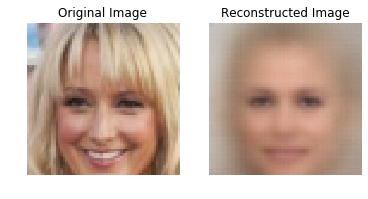

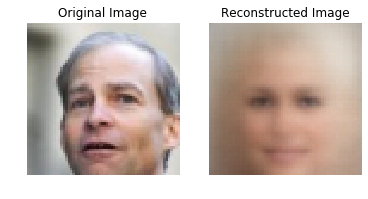

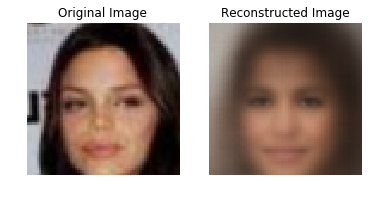

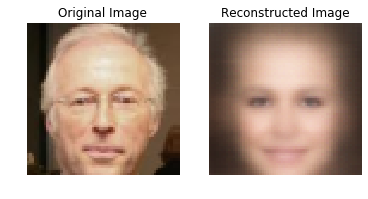

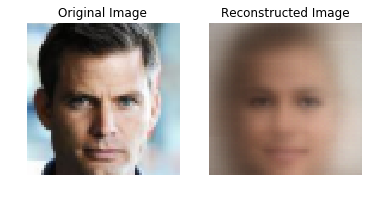

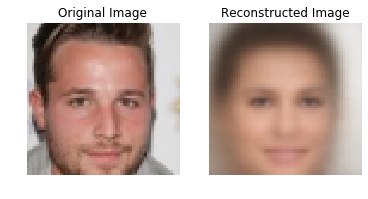

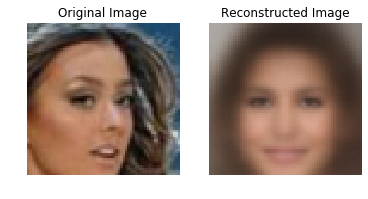

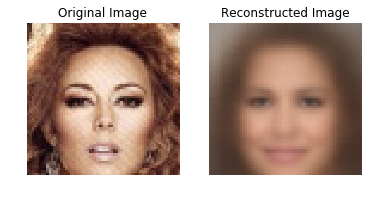

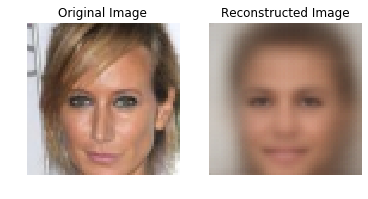

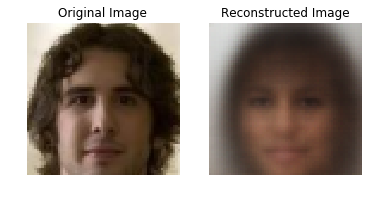

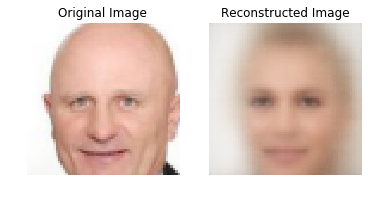

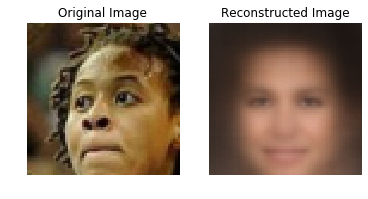

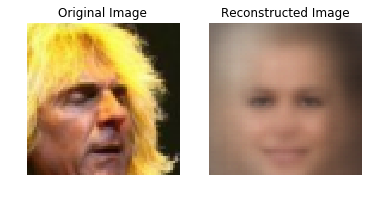

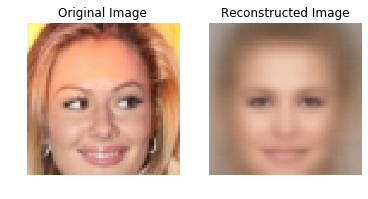

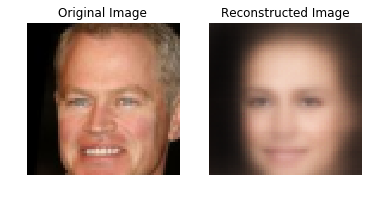

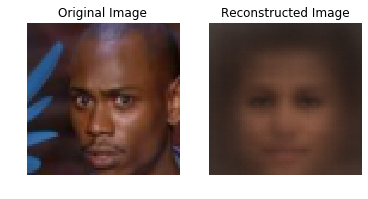

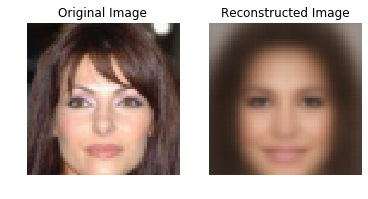

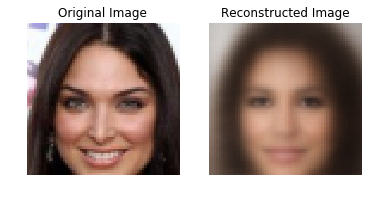

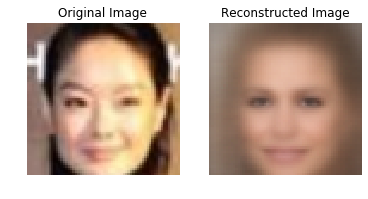

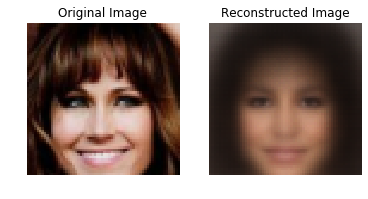

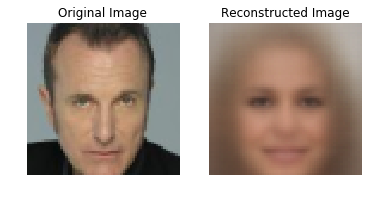

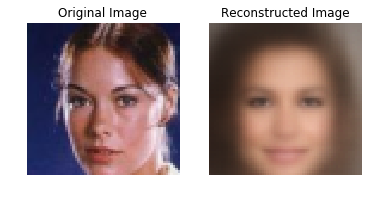

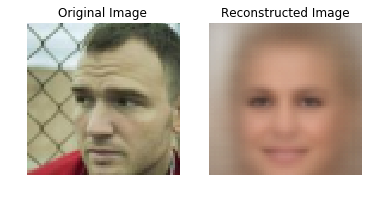

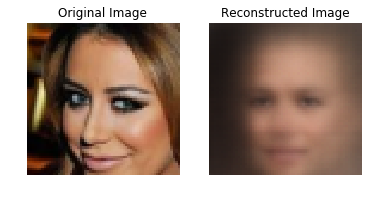

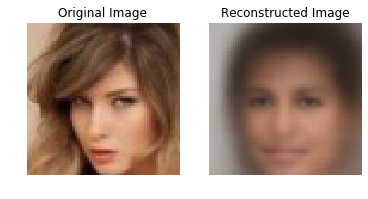

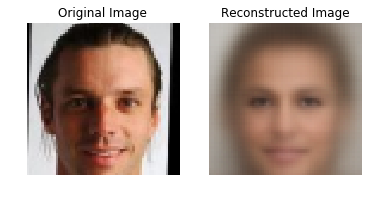

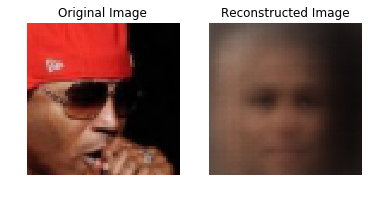

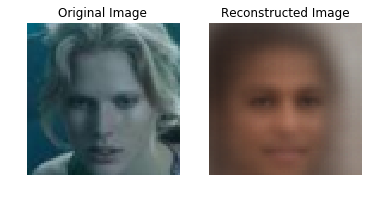

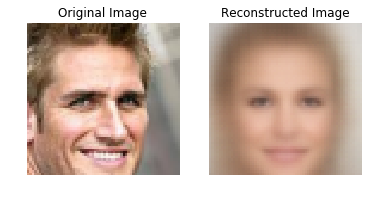

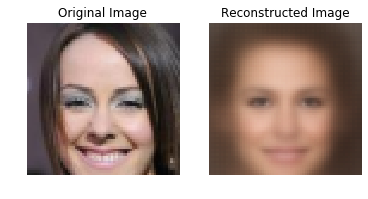

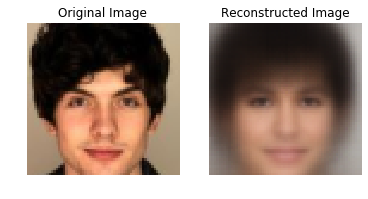

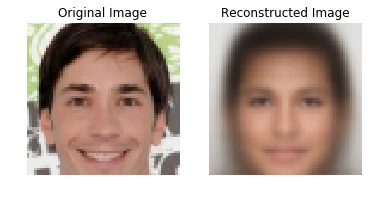

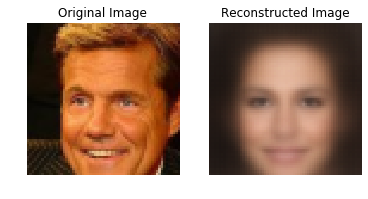

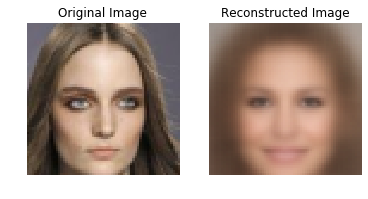

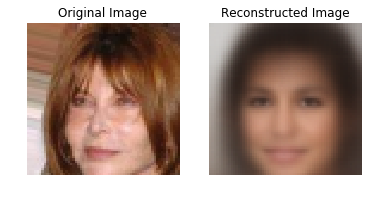

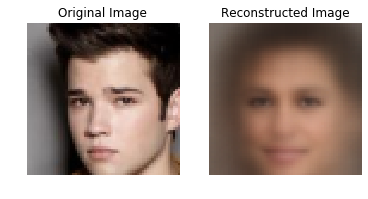

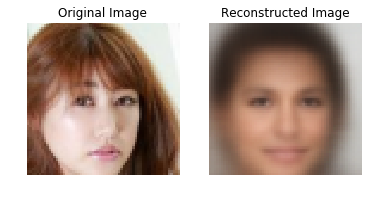

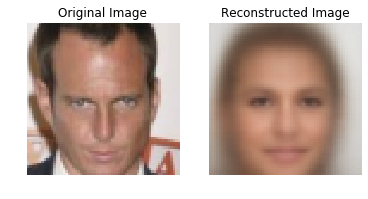

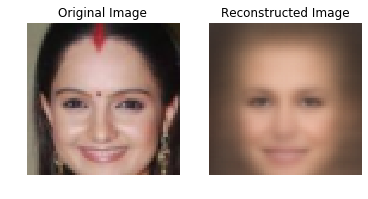

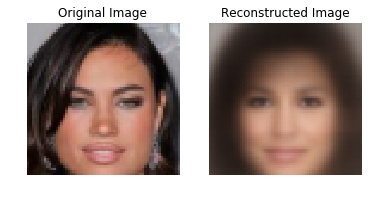

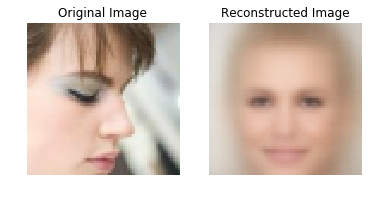

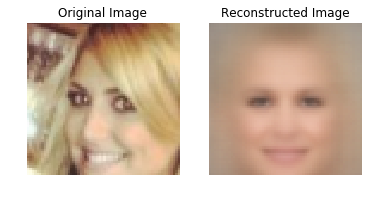

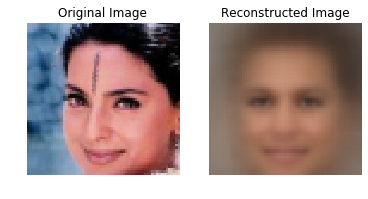

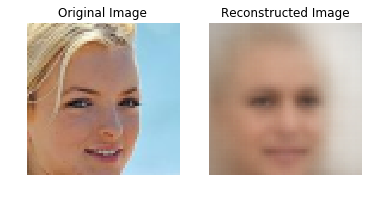

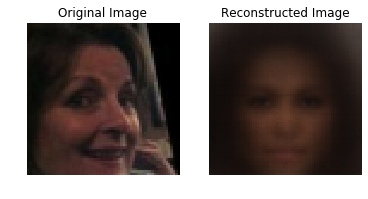

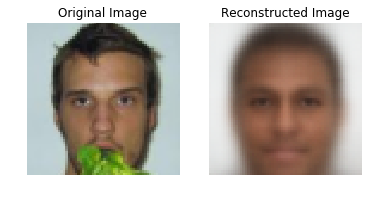

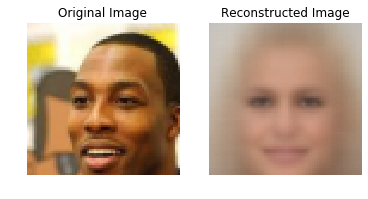

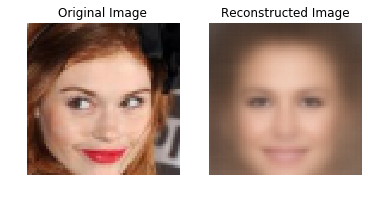

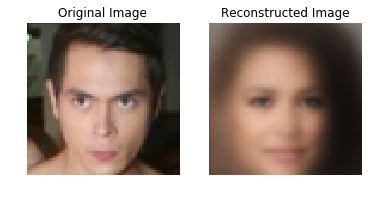

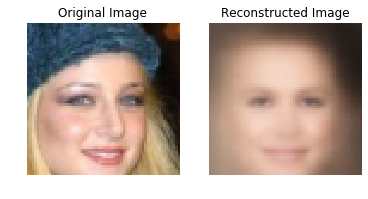

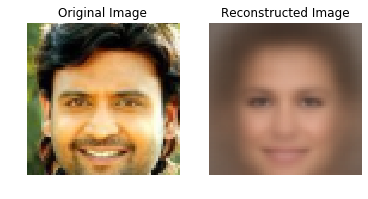

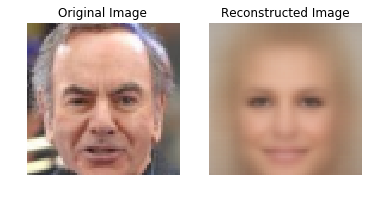

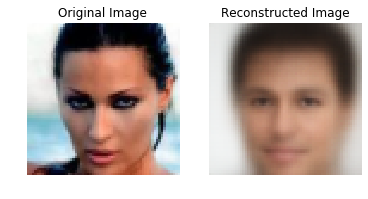

In [11]:
if train_model:
    # Training
    len_data = len(celebA_list)

    count_step = 0 

    for i in range(num_epoch):
        # Shuffle the data 
        np.random.shuffle(celebA_list)

        # Making mini-batch
        for j in range(0, len_data, batch_size): 
            if j + batch_size < len_data:
                data_x_in = np.zeros([batch_size, img_size, img_size, 3])

                for k in range(batch_size):
                    img_temp = cv2.imread(celebA_list[j + k])
                    data_x_in[k,:,:,:] = img_temp[45:45 + img_size, 25: 25+img_size, :]
            else:
                data_x_in = np.zeros([len_data - j, img_size, img_size, 3])

                for k in range(len_data - j):
                    img_temp = cv2.imread(celebA_list[j + k])
                    data_x_in[k,:,:,:] = img_temp[45:45 + img_size, 25: 25+img_size, :]
            
            x_in_resize = np.zeros([data_x_in.shape[0], img_resize_size, img_resize_size, 3])

            for k in range(data_x_in.shape[0]):
                x_in_resize[k,:,:,:] = resize(data_x_in[k,:,:,:], (img_resize_size, img_resize_size))
                    
            # Run Optimizer!
            _, loss_cr, loss_kl = sess.run([train_step, loss1, loss2], feed_dict = {x: x_in_resize, is_training: True})

            print("Epoch: {}, Batch: {} / {}, Loss Cr: {}, Loss KL: {}".format(i, j, len_data, loss_cr, loss_kl), end="\r")
            
            count_step += 1
            
            if count_step % show_result_step == 0:
                idx = random.randint(0,x_in_resize.shape[0]-1)
                output = sess.run([y], feed_dict = {x: [x_in_resize[idx,:]], is_training: False})
        
                f, ax = plt.subplots(1,2)
                sample_RGB = cv2.cvtColor(np.float32(x_in_resize[idx, :]/255.0), cv2.COLOR_BGR2RGB)
                ax[0].imshow(sample_RGB)
                ax[0].axis('off')
                ax[0].set_title('Original Image')
                
                out_RGB = cv2.cvtColor(np.float32(output[0][0,:]), cv2.COLOR_BGR2RGB)
                ax[1].imshow(out_RGB)
                ax[1].axis('off')
                ax[1].set_title('Reconstructed Image')
                
                plt.show()
        

## Test (Reconstruction)

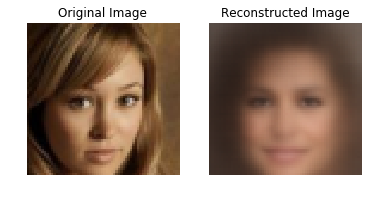

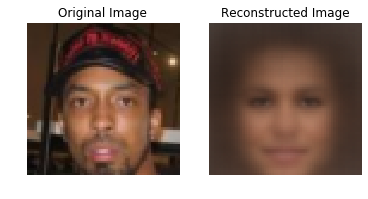

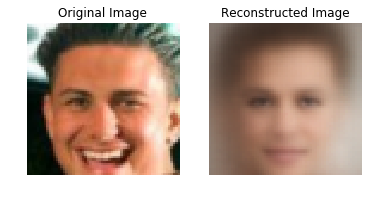

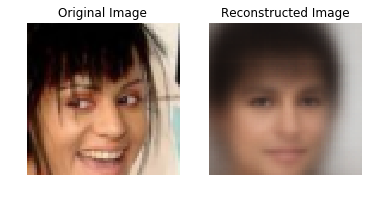

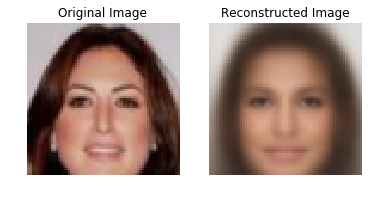

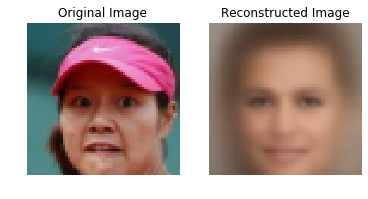

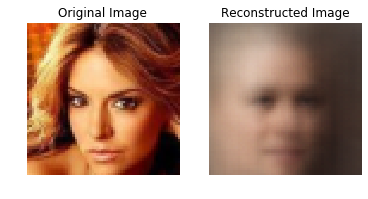

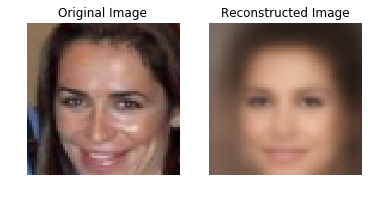

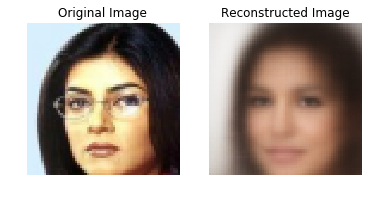

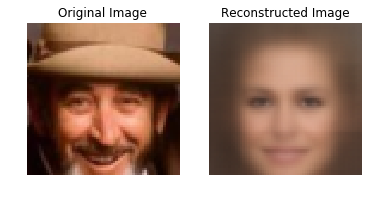

In [12]:
num_test = 10

np.random.shuffle(celebA_list)

data_x_test = np.zeros([num_test, img_size, img_size, 3])

x_test_resize = np.zeros([num_test, img_resize_size, img_resize_size, 3])

for i in range(num_test):
    img_temp = cv2.imread(celebA_list[i])
    data_x_test[i,:,:,:] = img_temp[45:45 + img_size, 25: 25+img_size, :]

    x_test_resize[i,:,:,:] = resize(data_x_test[i,:,:,:], (img_resize_size, img_resize_size))
                
for i in range(num_test):   
    output, mu, sigma = sess.run([y, mean, std], feed_dict = {x: [x_test_resize[i,:]], is_training: False})

    f, ax = plt.subplots(1,2)
    sample_RGB = cv2.cvtColor(np.float32(x_test_resize[i, :]/255.0), cv2.COLOR_BGR2RGB)
    ax[0].imshow(sample_RGB)
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    out_RGB = cv2.cvtColor(np.float32(output[0]), cv2.COLOR_BGR2RGB)
    ax[1].imshow(out_RGB)
    ax[1].axis('off')
    ax[1].set_title('Reconstructed Image')

plt.show()

## Print Average mu & sigma

In [13]:
print("Average mu: {}".format(np.mean(mu)))
print("Average std: {}".format(np.mean(sigma)))

Average mu: -0.012695493176579475
Average std: 0.9738806486129761


## Changing Latent Space

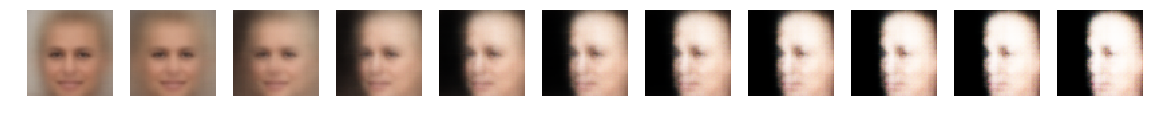

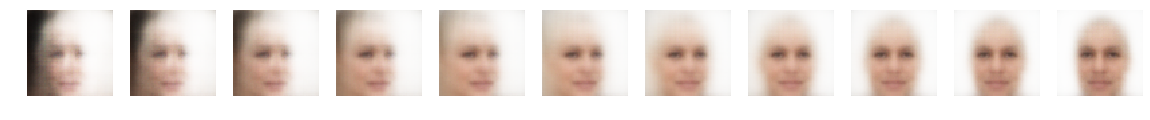

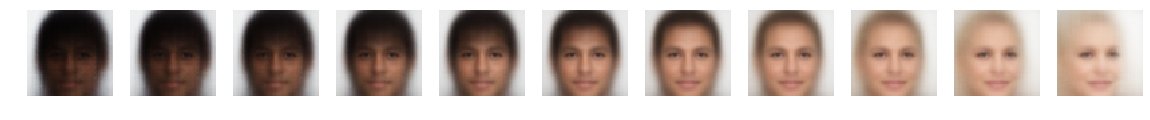

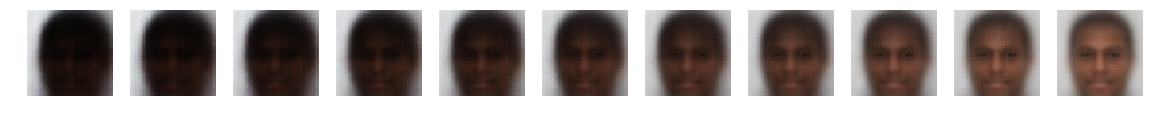

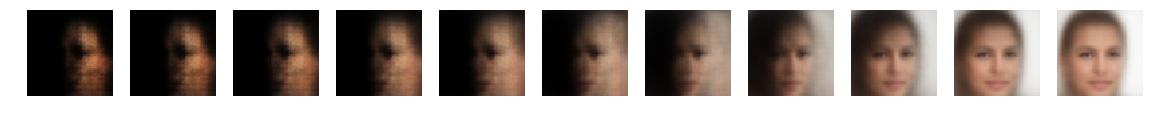

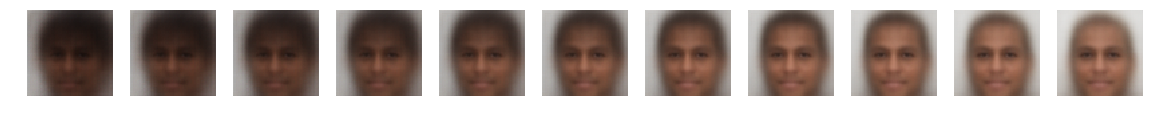

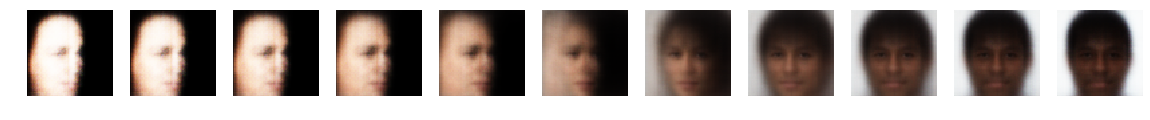

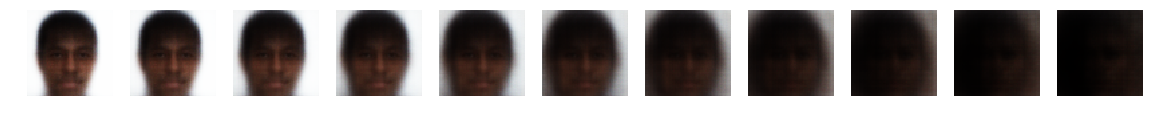

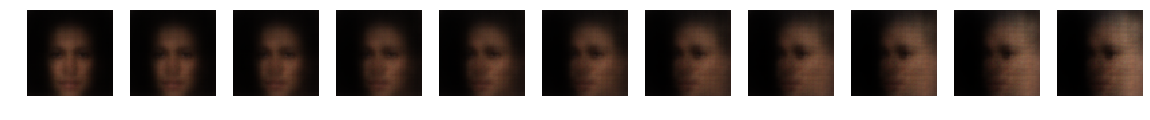

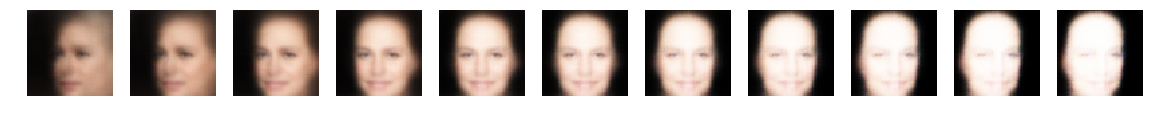

In [17]:
for i in range(num_test):
    z1 = np.random.normal(0, 1, n_latent)
    z2 = np.random.normal(0, 1, n_latent)

    output_list = []

    for j in range(11):
        z_in = (j/10) * z1 + (1 - (j/10)) * z2

        output = sess.run(y, feed_dict = {z: [z_in], is_training: False})
        out_RGB = cv2.cvtColor(np.float32(output[0]), cv2.COLOR_BGR2RGB)

        output_list.append(out_RGB)

    f, ax = plt.subplots(1,11,figsize=(20,15))

    for j in range(len(output_list)):
        ax[j].imshow(output_list[j], cmap = 'gray')
        ax[j].axis('off')

    plt.show()

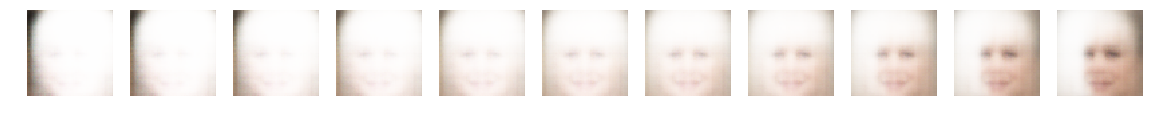

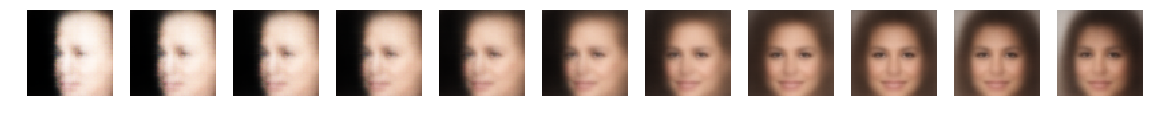

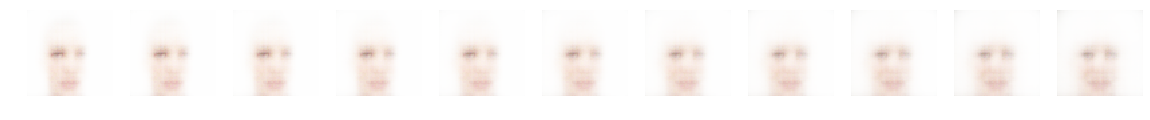

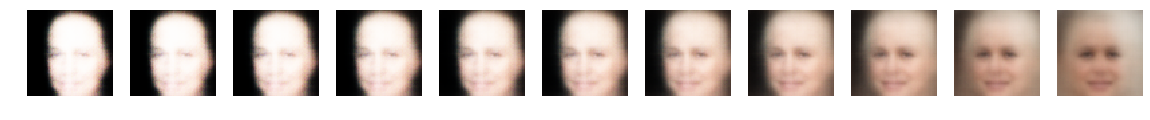

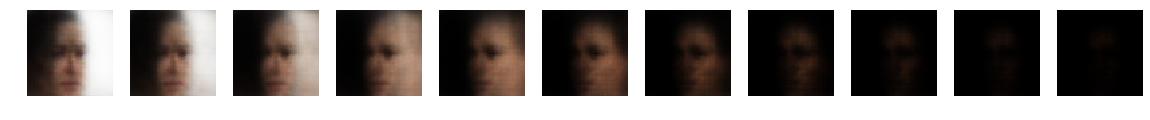

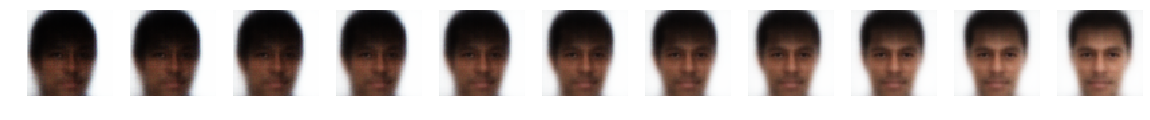

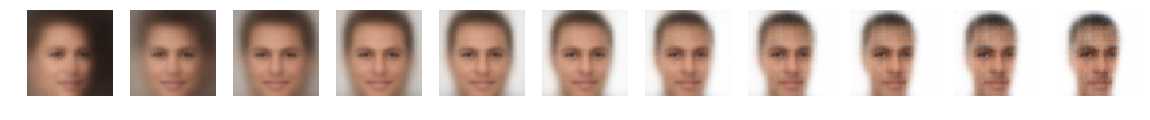

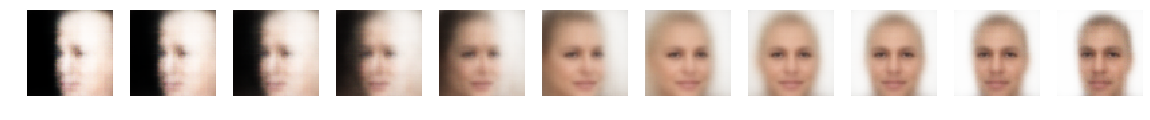

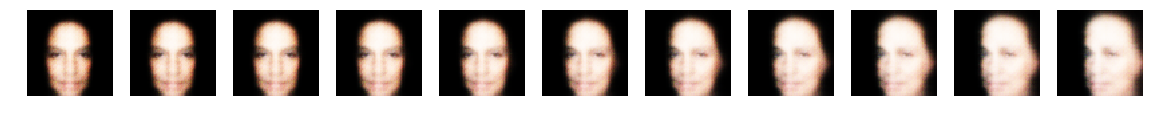

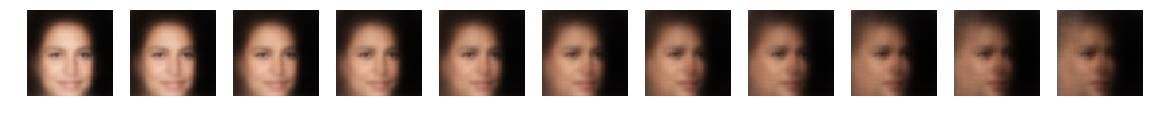

In [18]:
for i in range(num_test):
    z1 = np.random.normal(0, 1, n_latent)
    z2 = np.random.normal(0, 1, n_latent)

    output_list = []

    for j in range(11):
        z_in = (j/10) * z1 + (1 - (j/10)) * z2

        output = sess.run(y, feed_dict = {z: [z_in], is_training: False})
        out_RGB = cv2.cvtColor(np.float32(output[0]), cv2.COLOR_BGR2RGB)

        output_list.append(out_RGB)

    f, ax = plt.subplots(1,11,figsize=(20,15))

    for j in range(len(output_list)):
        ax[j].imshow(output_list[j], cmap = 'gray')
        ax[j].axis('off')

    plt.show()

## Save Model

In [15]:
os.mkdir(save_path)

Saver.save(sess, save_path + "/model/model")
print("Model is saved in {}".format(save_path + "/model/model"))

Model is saved in ./saved_models/20191129-20-15-49_VAE_CelebA/model/model
